In [ ]:
## Load packages

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import linearmodels as lm
from scipy import stats
from regpyhdfe import Regpyhdfe
from fixedeffect.fe import fixedeffect
from stargazer.stargazer import Stargazer
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys
import gc
import glob
import time
import string 
import subprocess
import warnings
import dli

pd.options.mode.chained_assignment = None  # default='warn'

## Set directories

input = "<Directory>\\Data"
input_econ = "<Directory>\\Data\\Economic Data\\"
zip_dir = "<Directory>\\Data\\Financials"

output = "<Directory>\\Data\\"

res_out = "<Directory>\\Projects\\Systematic Macro Shocks\\Results"


#Daterange to be used:
    
#mindate = '09/31/2013'
#maxdate = '05/01/2022'
#maxdate = '01/01/2022'

#mindate = '09-30-2013'
mindate = '08-31-2013'
#maxdate = '04-30-2022'
#maxdate = '05-01-2022'
#maxdate = '12-31-2021'
maxdate = '09-30-2022'


#Set script directory to current working directory:
    
script = os.getcwd()
#os.chdir(script+'\\Data')
os.chdir('<Directory>')

In [21]:
##Load economic data:

#Economic policy uncertainty (Baker et al. 2016):
url="https://policyuncertainty.com/media/All_Country_Data.xlsx"
epu = pd.read_excel(url, skipfooter=29)

#Monetary policy uncertainty (Baker et al. 2016):
url="https://www.policyuncertainty.com/media/US_MPU_Monthly.xlsx"
mpu = pd.read_excel(url, skiprows=range(0), skipfooter=1)

#Climate policy uncertainty (Gavriilidis 2021):
#url="https://www.policyuncertainty.com/media/CPU%20index.csv"
#cpu = pd.read_csv(url, skiprows=range(2))
cpu = pd.read_csv(input_econ+"Climate_Policy_Uncertainty.csv", skiprows=range(2))  

#Geopolitical risk index:
url="https://www.matteoiacoviello.com/gpr_files/data_gpr_export.xls"
gr = pd.read_excel(url)

#Macroeconomic and financial uncertainty (Jurado et al. 2015 and Ludvigson et al. 2021):  
url="https://www.sydneyludvigson.com/s/MacroFinanceUncertainty_202208Update.zip"
resp = urlopen(url)
zipfile = ZipFile(BytesIO(resp.read()))
fintu = pd.read_excel(zipfile.open(zipfile.namelist()[0]), sheet_name='Total Financial Uncertainty')
fineu = pd.read_excel(zipfile.open(zipfile.namelist()[0]), sheet_name='Economic Financial Uncertainty')
mactu = pd.read_excel(zipfile.open(zipfile.namelist()[1]), sheet_name='Total Macro Uncertainty')
maceu = pd.read_excel(zipfile.open(zipfile.namelist()[1]), sheet_name='Economic Macro Uncertainty')
realtu = pd.read_excel(zipfile.open(zipfile.namelist()[2]), sheet_name='Total Real Uncertainty')
realeu = pd.read_excel(zipfile.open(zipfile.namelist()[2]), sheet_name='Economic Real Uncertainty')

#Twitter economic uncertainty (Baker et al. 2021): 
tweu = pd.read_excel(input_econ+"Twitter_Economic_Uncertainty.xlsx")     
    
#Monetary policy uncertainty (US):
mpu_us = pd.read_excel(input_econ+"HRS_MPU_monthly.xlsx") 

##Load other financial/economic data:

#Volatility index (VIX):
    
url = "https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv"
vix = pd.read_csv(url)

#IHS purchasing manager index: 

#Logon and Authenticate to the Data Lake
dl = dli.connect()

#Loading Dataset
meta_ds = dl.datasets.get(short_code="PurchasingManagersIndexPMIMetadata")
ts_ds = dl.datasets.get(short_code="PurchasingManagersIndexPMITimeseries")

#Reading the Meta Data as a Dataframe
meta_df = meta_ds.dataframe(partitions=[f"as_of_date={meta_ds.last_datafile_at}"])
meta_df.sort_values('short_label', inplace=True)

#Check unique values of key columns and get the right meta information
regions=['Asia', 'Asia Excluding China, Japan', 'Asia Excluding China', 'Asia Excluding Japan',
         'China (mainland)', 'Developed Countries', 'Emerging Markets', 'Europe', 'European Union',
         'Eurozone', 'World', 'Japan', 'North America', 'United States']
meta_df = meta_df[(meta_df['economic_concept_name'].isin(['PMI', 'Headline'])) 
        & (meta_df['source_geographic_location_name'].isin(regions))
        & (meta_df['short_label'].str.contains('Composite')|meta_df['short_label'].str.contains('Manufacturing'))
        & (meta_df['series_type_name'] == 'Historical')]
 
#Reading the Time Series as a Dataframe
ts_df = ts_ds.dataframe(partitions=[f"as_of_date={ts_ds.last_datafile_at}"])

#Merge Timeseries with Metadata to get the required series 
df_PMI = pd.merge(ts_df, meta_df[['source_id', 'mnemonic', 'last_update', 
                                  'long_label', 'short_label', 
                                  'document_type', 'economic_concept_name',
                                  'source_geographic_location_name']], on="source_id")

    
## Merge data to one monthly dataset:

cpu['date'] = pd.to_datetime(cpu['date'], format='%b-%y')
cpu['month_id'] = pd.to_datetime(cpu['date']).dt.strftime('%Y-%m')

econ = cpu.copy(deep=True)
econ = econ[['month_id', 'cpu_index']]

mpu['month_id'] = pd.to_datetime(mpu[['Year', 'Month']].assign(DAY=1)).dt.strftime('%Y-%m') 
econ = pd.merge(econ, mpu.iloc[:,2:], on='month_id', how='outer')    
econ.sort_values(['month_id'], inplace=True)

mpu_us['Month'] = mpu_us['Month'].str.replace('m',' ')
mpu_us['month_id'] = pd.to_datetime(mpu_us['Month'], format='%Y %m').dt.strftime('%Y-%m')
econ = pd.merge(econ, mpu_us[['month_id', 'US MPU']], on='month_id', how='outer')    
econ.sort_values(['month_id'], inplace=True)

fintu['month_id'] = pd.to_datetime(fintu['Date']).dt.strftime('%Y-%m')
econ = pd.merge(econ, fintu[['month_id', 'h=1']], on='month_id', how='outer')   
econ.rename(columns={'h=1':'Financial Uncertainty'}, inplace=True)

mactu['month_id'] = pd.to_datetime(mactu['Date']).dt.strftime('%Y-%m')
econ = pd.merge(econ, mactu[['month_id', 'h=1']], on='month_id', how='outer')   
econ.rename(columns={'h=1':'Macro Uncertainty'}, inplace=True)

realtu['month_id'] = pd.to_datetime(realtu['Date']).dt.strftime('%Y-%m')
econ = pd.merge(econ, realtu[['month_id', 'h=1']], on='month_id', how='outer')   
econ.rename(columns={'h=1':'Real Uncertainty'}, inplace=True)
econ.sort_values(['month_id'], inplace=True)

tweu['month_id'] = pd.to_datetime(tweu['date']).dt.strftime('%Y-%m')
tweum = tweu.groupby(['month_id']).last().reset_index()
econ = pd.merge(econ, tweum[['month_id', 'TEU-ENG', 'TEU-SCA', 'TMU-ENG', 'TMU-SCA']], on='month_id', how='outer')    
econ.sort_values(['month_id'], inplace=True)

vix['month_id'] = pd.to_datetime(vix['DATE']).dt.strftime('%Y-%m')
vix['VIX_mean'] = vix.groupby(['month_id'])['CLOSE'].transform('mean')
vix = vix.groupby(['month_id']).last().reset_index()
econ = pd.merge(econ, vix[['month_id', 'CLOSE', 'VIX_mean']], on='month_id', how='outer')
econ.rename(columns={'CLOSE':'VIX'}, inplace=True)   

df_PMI["month_id"] = df_PMI["date"].dt.strftime("%Y-%m")
df_PMI = df_PMI.pivot(index="month_id", columns="source_id", values="value")
df_PMI = df_PMI.reset_index()
df_PMI = df_PMI[['month_id', '88505325', '93625215']]
df_PMI.rename(columns={'88505325':'Global Composite (M+S) PMI Headline Adjusted', 
                       '93625215':'Global Manufacturing PMI Adjusted'}, inplace=True)
econ = pd.merge(econ, df_PMI, on='month_id', how='outer')


## Load climate-related data:

#Media climate change concern index:
mccc = pd.read_excel(input_econ+"Sentometrics_US_Media_Climate_Change_Index.xlsx", 
                     sheet_name='SSRN 2022 version (monthly)', skiprows=range(5)) 

#Climate change news index:
ccn = mccc = pd.read_excel(input_econ+"EGLKS_data.xlsx") 

<AxesSubplot:title={'center':'Macro Shocks Heat Map'}, xlabel='Shock2', ylabel='Shock1'>

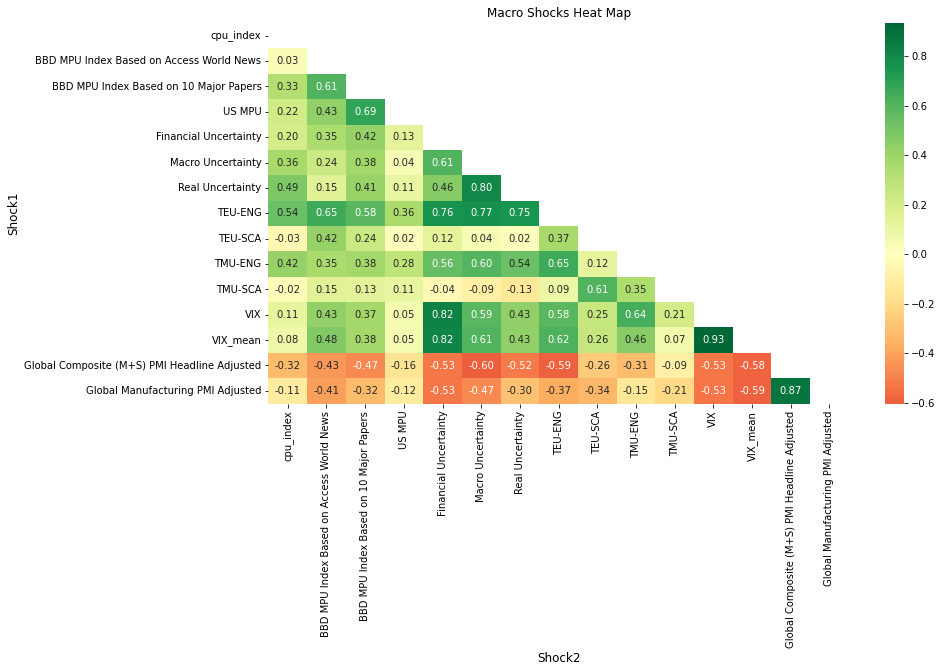

In [22]:
##Correlations between economic shock variables    
    
#ec = np.corrcoef(econ.loc[:,'cpu_index':'VIX_mean'])   
#ec = econ.loc[:,'cpu_index':'VIX_mean'].corr()
ec = econ.loc[:,'cpu_index':].corr()
#print(ec)

ec.index.name = 'Shock1' 
ec.columns.name = 'Shock2' 

fig, ax = plt.subplots(figsize=(13,7))
plt.title("Macro Shocks Heat Map",fontsize=12)
plt.xlabel('Shock1', fontsize = 12)
plt.ylabel('Shock2', fontsize = 12)
#sns.heatmap(ec)
#sns.heatmap(ec, mask=np.triu(ec))
#sns.heatmap(ec, mask=np.triu(ec), annot=True, fmt='.2f', center = 0, cmap=sns.diverging_palette(20,120,n=256))
sns.heatmap(ec, mask=np.triu(ec), annot=True, fmt='.2f', center = 0, cmap='RdYlGn')

<AxesSubplot:title={'center':'Macro Shocks Heat Map'}, xlabel='Shock2', ylabel='Shock1'>

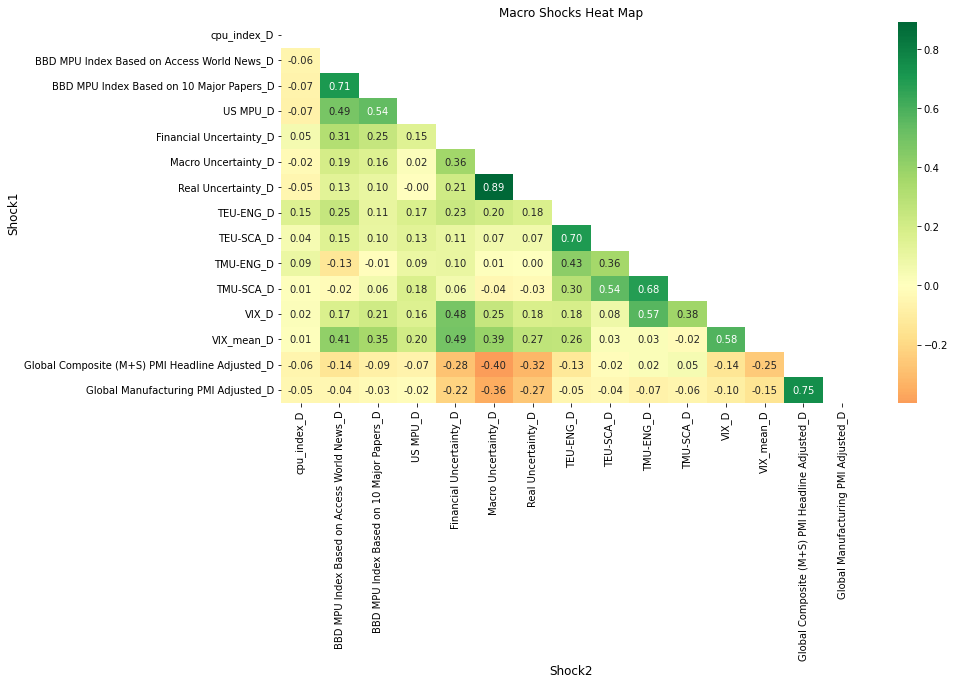

In [23]:
## Correlations between changes in economic shock variables   

econ.sort_values(['month_id'], inplace=True)
econd = econ.copy(deep=True)

for v in econd.columns[1:]:
    econd[v+'_L'] = econd[v].shift(1)
    econd[v+'_D'] = econd[v]-econd[v+'_L']
    econd.drop([v+'_L'], axis=1, inplace=True) 
    
ec = econd.loc[:,'cpu_index_D':].corr()

ec.index.name = 'Shock1' 
ec.columns.name = 'Shock2' 

fig, ax = plt.subplots(figsize=(13,7))
plt.title("Macro Shocks Heat Map",fontsize=12)
plt.xlabel('Shock1', fontsize = 12)
plt.ylabel('Shock2', fontsize = 12)
#sns.heatmap(ec)
#sns.heatmap(ec, mask=np.triu(ec))
#sns.heatmap(ec, mask=np.triu(ec), annot=True, fmt='.2f', center = 0, cmap=sns.diverging_palette(20,120,n=256))
sns.heatmap(ec, mask=np.triu(ec), annot=True, fmt='.2f', center = 0, cmap='RdYlGn')

In [18]:
##Load stock market data:    
 
ret = pd.read_csv(input+'\\Financials\\firm_returns_monthly.csv', low_memory=False)
#ret = pd.read_csv(input_dir+'\\Financials\\returns_monthly.csv', low_memory=False)

#ind = pd.read_csv(input+'\\Financials\\industries_monthly.csv', low_memory=False)
zipfile = ZipFile(input+'\\Financials\\industries.zip')
ind = pd.read_csv(zipfile.open(zipfile.namelist()[0]))  

#ret = pd.merge(ret, ind, on=['issue_id', 'month_id', 'Date', 'company_name',
#                            'capital_iq', 'snlinstitutionid'])
#ret = pd.merge(ret, ind, on=['issue_id', 'month_id', 'company_name',
#                             'capital_iq', 'snlinstitutionid'], suffixes=['', '_ind'], indicator=True)
ret = pd.merge(ret, ind, on=['capital_iq', 'month_id'], suffixes=['', '_ind'], 
               indicator=True, how='inner')

print(ret['_merge'].value_counts())
ret.drop(['_merge'], axis=1, inplace=True)

try:
    ret = ret.drop(['Unnamed: 0'], axis = 1)
except:
    pass

ret = ret.rename(columns={'capital_iq':'CIQ_ID'})
#ret['month_id'] = pd.to_datetime(ret['month_id']).dt.to_period("M")

for m in ['market_cap', 'market_cap_usd']:
    ret[m] = ret.groupby('CIQ_ID')[m].shift(1)
    ret[m] = ret[m]/1000

# Drop if CIQ ID not available:
ret = ret[~ret['CIQ_ID'].isnull()]

ind = ind.rename(columns={'capital_iq':'CIQ_ID'})
ind['month_id'] = pd.to_datetime(ind['month_id']).dt.to_period("M")

gc.collect()

# Prepare data filtering:

countf = pd.read_csv(input+'\\Financials\\zero_return_filter.csv', low_memory=False)


both          8402325
left_only           0
right_only          0
Name: _merge, dtype: int64


In [19]:
# %%Apply filters:

# Winsorize returns by month at 1% and 99% percentiles
# Set max return to 300% if cumulative 2 month return less than 50%
# Set min excess return to -100%

print(len(ret))

def month_return_adjust(rd, ret_vars):
    for r in ret_vars:
        rd[r+'2'] = ((1+rd[r])*(1+rd[r].shift())-1)*100
        rd[r] = rd[r]*100
        #rd[r] = rd.groupby('month_id')[r].transform(lambda x: stats.mstats.winsorize(x, 
        #                                                                             limits=[0.01, 0.01]))
        #rd[r] = rd.groupby('month_id')[r].transform(lambda x: np.maximum(x.quantile(.01), 
        #                                                                 np.minimum(x, x.quantile(.99))))
        #rd.loc[(rd[r]>300)&(rd[r+'2']<50),r] = 300 
        rd.loc[(rd[r]>300)&(rd[r+'2']<50),r] = np.nan
        rd.loc[rd[r]<-100,r] = -100 
    
    return rd

ret.sort_values(['CIQ_ID', 'month_id'], inplace=True)

ret = month_return_adjust(ret, ['ret', 'ret_usd'])

# Drop small and illiquid firms:

#ret = ret[ret['cshtrd'] != 0]
ret = ret[ret['cshtrm'] != 0]
ret = ret[~((ret['prccd_usd']<1) & (ret['ret_usd']>300))]
ret = ret[~((ret['prccd_usd']<1) & (ret['ret_usd']<=-80))]
# data = data[data['prccd_usd']>1]
# data = data[data['market_cap_usd']>1]
# data = data[~((data['prccd_usd']<0.5) & (data['market_cap_usd']<1))]
print(len(ret))

# Drop if more than 30% zero return days per year

ret['year_id'] = pd.to_datetime(ret['Date']).dt.strftime('%Y').astype(int)
#ret = pd.merge(ret, countf, on=['issue_id', 'year_id'])
countf = countf.rename(columns={'capital_iq':'CIQ_ID'})
ret = pd.merge(ret, countf, on=['CIQ_ID', 'year_id'], how='left', indicator = True)
ret.loc[ret['perf'].isnull(), 'perf'] = 0.5
ret = ret[ret['perf'] < 0.3]
print(len(ret))

# Number of firms per country and month, require at least 10:

firms = ret.groupby(['country', 'month_id'])['ret'].count()
firms = firms.reset_index()
firms.rename(columns={'ret': 'firmno'}, inplace=True)

ret = pd.merge(ret, firms, on=['country', 'month_id'], how='outer')
ret = ret[ret['firmno'] >= 10]
print(len(ret))

# Drop time period where CSA data not available:

ret = ret[pd.to_datetime(ret['Date']) > '01-01-2013']
ret.drop('_merge', axis=1, inplace=True)
print(len(ret))

gc.collect()

8402325
8393564
5802492
5777847
3165999


50

In [24]:
##Merge macroeconomic and stock market data

#ret = pd.merge(ret, econ, on='month_id', how='left')
ret = pd.merge(ret, econd, on='month_id', how='left')
ret['month_id'] = pd.to_datetime(ret['month_id']).dt.to_period("M")
econ['month_id'] = pd.to_datetime(econ['month_id']).dt.to_period("M")
econd['month_id'] = pd.to_datetime(econd['month_id']).dt.to_period("M")
ret.sort_values(['CIQ_ID', 'month_id'], inplace=True)

print(ret.columns)

gc.collect()

Index(['company_id', 'month_id', 'Date', 'cusip', 'company_name', 'isin',
       'issue_id', 'ticker', 'CIQ_ID', 'gvkey', 'prccd_usd', 'prccd',
       'prccd_unadj_usd', 'prccd_unadj', 'cshtrm', 'cshoc', 'cshoc_unadj',
       'market_cap_usd', 'market_cap', 'ret_usd', 'ret', 'Date_ind',
       'iso_code', 'company_id_ind', 'country', 'currency', 'industry',
       'region', 'sector', 'sub_industry', 'sub_sector', 'gticker',
       'gvkey_ind', 'calendarYear', 'filingDate', 'fiscalYear', 'ret2',
       'ret_usd2', 'year_id', 'perf', 'firmno', 'cpu_index',
       'BBD MPU Index Based on Access World News',
       'BBD MPU Index Based on 10 Major Papers', 'US MPU',
       'Financial Uncertainty', 'Macro Uncertainty', 'Real Uncertainty',
       'TEU-ENG', 'TEU-SCA', 'TMU-ENG', 'TMU-SCA', 'VIX', 'VIX_mean',
       'Global Composite (M+S) PMI Headline Adjusted',
       'Global Manufacturing PMI Adjusted', 'cpu_index_D',
       'BBD MPU Index Based on Access World News_D',
       'BBD MPU Ind

In [26]:
#Import ESG data

import csa_data_exec

csa = csa_data_exec.csa_import()

print('Executed')

csa = csa[csa['_merge']=='both']

#csa.drop(['CAM_ID', 'CAM_NAME', 'CAM_TYPE', 'EVR_PUBLISH_TIME', 'EVR_ID',
#          'aspect_type', 'Potential Score Contribution Combined', 'Data Availability Public',
#          'Data Availability Private', 'Data Availability Combined', 'SCORE_IMP_TEMP', '_merge'], 
#          axis=1, inplace=True)
csa.drop(['Potential Score Contribution Combined', 'Data Availability Public',
          'Data Availability Private', 'Data Availability Combined', 'SCORE_IMP_TEMP', '_merge'], 
          axis=1, inplace=True)
gc.collect()

#Only keep the respective level of aggregated scores

#csa['CAM_TYPE'].value_counts()
#csa = csa[csa['CAM_TYPE']=='CA']

question = csa[csa['QUESTION'].notnull()]
criterion = csa[(csa['QUESTION'].isnull())&(csa['CRITERION'].notnull())]
dimension = csa[(csa['QUESTION'].isnull())&(csa['CRITERION'].isnull())&(csa['DIMENSION'].notnull())]
esg = csa[(csa['QUESTION'].isnull())&(csa['CRITERION'].isnull())&(csa['DIMENSION'].isnull())]

#Set the score to be used in sorting:

#Potential choices are: 
#SCORE: classical scores, SCORE_IMP: imputed scores, SCORE_IMP_NP: imputed scores without disclosure penalization

#score = 'SCORE'
#score = 'SCORE_IMP'
#score = 'SCORE_IMP_NP'

Executed


In [27]:
#Prepare wide tables

#In wide tables the different score levels are next to each other instead of below each other, this enables sorting for multiple variables 

#ESG

esg.loc[esg['DIMENSION'].isnull(), 'DIMENSION'] = "ESG"

esg.sort_values(['CSF_LCID', 'month_id'], inplace=True)
firm_inf = esg.groupby(['CSF_LCID', 'month_id'])['INDUSTRY', 'INDUSTRYGROUP', 
                                                 'CSF_LONGNAME', 'ISIN', 'GVKEY', 
                                                 'CIQ_ID', 'COUNTRYNAME', 'DJREGION',
                                                 'Date', 'CAM_YEAR', 'ASOF_DATE'].last()

#esg = esg.pivot_table(index=['CSF_LCID', 'month_id'], 
#                      columns='DIMENSION', values=score)

esgs = esg.pivot_table(index=['CSF_LCID', 'month_id'], 
                      columns='DIMENSION', values='SCORE')
esgi = esg.pivot_table(index=['CSF_LCID', 'month_id'], 
                      columns='DIMENSION', values='SCORE_IMP')
esgn = esg.pivot_table(index=['CSF_LCID', 'month_id'], 
                      columns='DIMENSION', values='SCORE_IMP_NP')
esg = pd.merge(esgs, esgi, left_index=True, right_index=True, how='outer', suffixes=('',' Imp'))
esg = pd.merge(esg, esgn, left_index=True, right_index=True, how='outer', suffixes=('',' NP'))

esg = pd.merge(esg, firm_inf, left_index=True, right_index=True)
esg = esg.reset_index()

del esgs
del esgi
del esgn

#Dimension:
 
dimension.replace({'DIMENSION':{'Economic Dimension':'Governance & Economic Dimension'}},
                 inplace=True)

#dimension = dimension.pivot_table(index=['CSF_LCID', 'month_id'], 
#                                  columns='DIMENSION', values=score)
   
dimensions = dimension.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='DIMENSION', values='SCORE')
dimensioni = dimension.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='DIMENSION', values='SCORE_IMP')
dimensionn = dimension.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='DIMENSION', values='SCORE_IMP_NP')
dimension = pd.merge(dimensions, dimensioni, left_index=True, right_index=True, how='outer', suffixes=('',' Imp'))
dimension = pd.merge(dimension, dimensionn, left_index=True, right_index=True, how='outer', suffixes=('',' NP'))

dimension = pd.merge(dimension, firm_inf, left_index=True, right_index=True)
dimension = dimension.reset_index()

del dimensions
del dimensioni
del dimensionn

#Criterion

# Only include criteria that have been used in the most recent CSA data vintage
# Historically, there were 104 aspects with 119 names, currently (2021) there are 68 aspects, 56 are available for the full period

csas = csa.groupby(['CAM_YEAR', 'ASP_LCID']).last()
csas.sort_values(['ASP_LCID', 'CAM_YEAR'], inplace=True)
csas = csas.reset_index()

csac = csas[(csas['QUESTION'].isnull()) & (csas['CRITERION'].notnull())]
csacl = csac[csac['CAM_YEAR'] == 2021]
csacl = csacl[['ASP_LCID', 'CRITERION']]

criterion.drop(['DIMENSION', 'CRITERION', 'QUESTION'], axis=1, inplace=True)
criterion = pd.merge(criterion, csacl, on=['ASP_LCID'], how='inner')

#Only use criteria that have been available in at least the last 6 years

#vc = csac['CRITERION'].value_counts()
vc = csac['ASP_LCID'].value_counts()

years = 6
#years = max(vc)
vc = vc[vc >= years].reset_index()
vc.rename(columns={'index': 'ASP_LCID',
                   'ASP_LCID': 'CRITERIONYEARS'}, inplace=True)

criterion = pd.merge(criterion, vc, on=['ASP_LCID'], how='inner')

firm_inf = criterion.groupby(['CSF_LCID', 'month_id'])['INDUSTRY', 'SECTOR', 'INDUSTRYGROUP',
                                                       'CSF_LONGNAME', 'ISIN', 'GVKEY',
                                                       'CIQ_ID', 'COUNTRYNAME', 'DJREGION',
                                                       'Date', 'CAM_YEAR', 'ASOF_DATE',
                                                       'CRITERIONYEARS'].last()

#criterion = criterion.pivot_table(index=['CSF_LCID', 'month_id'], 
#                                  columns='CRITERION', values=score)

#crit = ['Biodiversity', 'Brand Management', 'Climate Strategy', 'Corporate Governance',
crit = ['Corporate Governance', 'Climate Strategy',
'Customer Relationship Management', 'Environmental Policy & Management Systems', 
'Environmental Reporting', 'Innovation Management', 'Supply Chain Management']

criterions = criterion.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='CRITERION', values='SCORE')
criterioni = criterion.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='CRITERION', values='SCORE_IMP') 
criterionn = criterion.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='CRITERION', values='SCORE_IMP_NP')                                  
#criterions = criterions[crit]
#criterioni = criterioni[crit]
#criterionn = criterionn[crit]
criterion = pd.merge(criterions, criterioni, left_index=True, right_index=True, how='outer', suffixes=('',' Imp'))
criterion = pd.merge(criterion, criterionn, left_index=True, right_index=True, how='outer', suffixes=('',' NP'))

criterion = pd.merge(criterion, firm_inf, left_index=True, right_index=True)
criterion = criterion.reset_index()

del criterions
del criterioni
del criterionn

#Question

#Only include questions that have been used in the most recent CSA data vintage
#Some question have been renamed, however, they have the same aspect identifier
# Historically, there were 642 aspects with 757 names, currently (2021) there are 325 aspects, 188 are available for the full period

#csaq = csas[csas['CAM_YEAR'] == 2021]
#csaq = csaq[csaq['QUESTION'].notnull()]
#csaq = csaq[['ASP_LCID', 'QUESTION']]

csaq = csas[csas['QUESTION'].notnull()]
csaql = csaq[csaq['CAM_YEAR'] == 2021]
csaql = csaql[['ASP_LCID', 'QUESTION']]

question.drop(['DIMENSION', 'CRITERION', 'QUESTION'], axis=1, inplace=True)
question = pd.merge(question, csaql, on=['ASP_LCID'], how='inner')

#Only use questions that have been available in at least the last 6 years

#vc = csaq['QUESTION'].value_counts()
vc = csaq['ASP_LCID'].value_counts()

years = 6
#years = max(vc)
vc = vc[vc >= years].reset_index()
vc.rename(columns={'index': 'ASP_LCID',
                   'ASP_LCID': 'QUESTIONYEARS'}, inplace=True)

question = pd.merge(question, vc, on=['ASP_LCID'], how='inner')

firm_inf = question.groupby(['CSF_LCID', 'month_id'])['INDUSTRY', 'SECTOR', 'INDUSTRYGROUP',
                                                      'CSF_LONGNAME', 'ISIN', 'GVKEY',
                                                      'CIQ_ID', 'COUNTRYNAME', 'DJREGION',
                                                      'Date', 'CAM_YEAR', 'ASOF_DATE',
                                                      'QUESTIONYEARS'].last()

#question = question.pivot_table(index=['CSF_LCID', 'month_id'], 
#                                columns='QUESTION', values=score)

#qu = ['Climate Change Strategy', 'Climate Strategy Impacts', 'Corruption & Bribery',
qu = ['Corruption & Bribery',
'Direct Greenhouse Gas Emissions (Scope 1)', 'ESG Integration in SCM Strategy',
'Environmental Reporting - Assurance', 'Environmental Reporting - Coverage',
'Financial Opportunities Arising from Climate Change',
'Financial Risks of Climate Change', 'Indirect Greenhouse Gas Emissions (Scope 2)',
'Sensitivity Analysis & Stress Testing (including Water and Climate)',
'Supply Chain Risk Exposure', 'Waste Disposal', 'Water Use']
#'Internal Carbon Pricing', 'Process Innovations', 'Environmental Violations' 

questions = question.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='QUESTION', values='SCORE')
questioni = question.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='QUESTION', values='SCORE_IMP')  
questionn = question.pivot_table(index=['CSF_LCID', 'month_id'], 
                                  columns='QUESTION', values='SCORE_IMP_NP')                                  
questions = questions[qu]
questioni = questioni[qu]
questionn = questionn[qu]
question = pd.merge(questions, questioni, left_index=True, right_index=True, how='outer', suffixes=('',' Imp'))
question = pd.merge(question, questionn, left_index=True, right_index=True, how='outer', suffixes=('',' NP'))

question = pd.merge(question, firm_inf, left_index=True, right_index=True)
question = question.reset_index()

del questions
del questioni
del questionn

gc.collect()

0

In [30]:
#Industry-demeaned and standardized levels

ind.rename(columns={'capital_iq':'CIQ_ID'}, inplace=True)

def industry_demean(data, ind):
    data = pd.merge(data, ind[['CIQ_ID', 'month_id', 'sector', 'sub_sector']], on=['CIQ_ID', 'month_id'], how='left')

    var_name = list(data.loc[:,'month_id':'INDUSTRY'].columns)
    var_name = var_name[1:-1]
    
    data.sort_values(['CSF_LCID', 'month_id'], inplace=True)

    #print(data.columns)
    
    for v in var_name:

        #Industry-demeaned:
        data[v+'_ind'] = data.groupby(['INDUSTRY', 'CAM_YEAR'])[v].transform('mean')
        #data[v+'_sd'] = data.groupby(['INDUSTRY', 'CAM_YEAR'])[v].transform('std')
        data[v+'_dm'] = data[v]-data[v+'_ind']

        data[v + '_mean'] = data.groupby(['CAM_YEAR'])[v + '_dm'].transform('mean')
        data[v + '_sd'] = data.groupby(['CAM_YEAR'])[v + '_dm'].transform('std')
        data[v + '_stdm'] = (data[v + '_dm'] - data[v + '_mean']) / data[v + '_sd']

        #Standardized:
        data[v+'_mean'] = data.groupby(['CAM_YEAR'])[v].transform('mean')
        data[v+'_sd'] = data.groupby(['CAM_YEAR'])[v].transform('std')
        data[v+'_std'] = (data[v]-data[v+'_mean'])/data[v+'_sd']

        #Sector-demeaned:
        #data[v+'_sec'] = data.groupby(['sector', 'CAM_YEAR'])[v].transform('mean')
        #data[v+'_dms'] = data[v]-data[v+'_sec']

        #Adjusted:
        #data[v+'_us'] = -(100-data[v])

        #data.drop([v+'_ind', v+'_sd', v+'_sec', v+'_mean'], axis=1, inplace=True)
        data.drop([v+'_ind', v+'_sd', v+'_mean'], axis=1, inplace=True)
        
    return data

question = industry_demean(question, ind)
criterion = industry_demean(criterion, ind)
dimension = industry_demean(dimension, ind)
esg = industry_demean(esg, ind)

del ind
del csa
gc.collect()

110

In [62]:
#Determine the type of CSA data to be analyzed:

#Possible choices are: esg, dimension, criterion, question
    
data = criterion.copy(deep=True)


#Levels:
var_name = list(data.loc[:,'month_id':'INDUSTRY'].columns)
var_name = var_name[1:-1]

#Industry-demeaned levels:
var_name_dm = list(data.loc[:,data.columns.str.endswith('_dm')].columns)

#Industry-standardized levels:
var_name_sd = list(data.loc[:,data.columns.str.endswith('_std')].columns)

#Industry-demeaned and full-sample standardized levels:
var_name_sdm = list(data.loc[:,data.columns.str.endswith('_stdm')].columns)

#Sector-demeaned levels:
#var_name_dms = list(data.loc[:,data.columns.str.endswith('_dms')].columns)

#Adjusted levels:
#var_name_us = list(data.loc[:,data.columns.str.endswith('_us')].columns)

try:
    data.drop(['_merge'], axis=1, inplace=True)
except:
    pass

data['month_id'] = pd.to_datetime(data['Date']) - pd.DateOffset(months=-1)
data['month_id'] = pd.to_datetime(data['month_id']).dt.to_period("M")

print('The following variables are analyzed: ' + str(var_name))

The following variables are analyzed: ['Addressing Cost Burden', 'Anti-Crime Policy & Measures', 'Asset Closure Management', 'Biodiversity', 'Brand Management', 'Building Materials', 'Climate Strategy', 'Codes of Business Conduct', 'Compliance with Applicable Export Control Regimes', 'Corporate Citizenship & Philanthropy', 'Corporate Governance', 'Customer Relationship Management', 'Efficiency & Reliability', 'Electricity Generation', 'Energy Mix', 'Environmental Policy & Management Systems', 'Environmental Reporting', 'Financial Inclusion', 'Financial Stability & Systemic Risk', 'Fleet Management', 'Fuel Efficiency', 'Genetically Modified Organisms', 'Health & Nutrition', 'Health Outcome Contribution', 'Human Capital Development', 'Information Security/ Cybersecurity & System Availability', 'Innovation Management', 'Labor Practice Indicators', 'Local Impact of Business Operations', 'Low Carbon Strategy', 'Market Opportunities', 'Marketing Practices', 'Materiality', 'Mineral Waste Mana

In [63]:
#Only keep one type of scores: classic, imputed, non-penalized
#Currently: Imputed scores

print(len(data.columns))

vars_all = list() 
for v in var_name:
    vars_all.extend(list(data.loc[:,data.columns.str.contains(v)].columns))

vars_imp =  [x for x in vars_all if 'Imp' in x]
vars_imp =  [x for x in vars_imp if 'Impa' not in x and 'Impr' not in x]
vars_np =  [x for x in vars_all if 'NP' in x]
vars_cla = [x for x in vars_all if x not in vars_imp and x not in vars_np]

data.drop(vars_np, axis=1, inplace=True)
data.drop(vars_cla, axis=1, inplace=True)


#Delete the adjusted data that is not needed 
#Currently: Industry-adjusted

vars_dm =  [x for x in vars_imp if x.endswith('_dm')]
vars_stdm =  [x for x in vars_imp if x.endswith('_stdm')]

data.drop(vars_dm, axis=1, inplace=True)
data.drop(vars_stdm, axis=1, inplace=True)


print(len(data.columns))
print(data.columns)

var_name =  [x for x in list(data.columns) if x.endswith('Imp')]
var_name_sd =  [x for x in list(data.columns) if x.endswith('_std')]

gc.collect()

725
129
Index(['CSF_LCID', 'month_id', 'Addressing Cost Burden Imp',
       'Anti-Crime Policy & Measures Imp', 'Asset Closure Management Imp',
       'Biodiversity Imp', 'Brand Management Imp', 'Building Materials Imp',
       'Climate Strategy Imp', 'Codes of Business Conduct Imp',
       ...
       'Stakeholder Engagement Imp_std',
       'Strategy for Emerging Markets Imp_std',
       'Supply Chain Management Imp_std',
       'Sustainable Agricultural Practices Imp_std',
       'Sustainable Forestry Practices Imp_std',
       'Talent Attraction & Retention Imp_std', 'Tax Strategy Imp_std',
       'Transmission & Distribution Imp_std', 'Water Operations Imp_std',
       'Water Related Risks Imp_std'],
      dtype='object', length=129)


4

In [64]:
#Merge financial data with csa data

data = pd.merge(ret, data, on=['CIQ_ID', 'month_id'], 
                how='outer', suffixes=['', '_csa'], indicator=True)

print(len(data))

#Keep specific dates

data = data[pd.to_datetime(data['Date']) > mindate]
data = data[pd.to_datetime(data['Date']) < maxdate]

data.sort_values(['CIQ_ID', 'month_id'], inplace=True)

print(data['_merge'].value_counts())
gc.collect()

#Forward fill, csa data to the next 24 months, industry data generally

info = [x for x in list(data.loc[:,'INDUSTRY':'CAM_YEAR'].columns) if x != 'CIQ_ID']

#Number of months to forward scores:
fw=24

data[['CSF_LCID', 
      'CAM_YEAR']] = data.groupby(['CIQ_ID'])[['CSF_LCID', 'CAM_YEAR']].ffill(limit=fw)
data[info] = data.groupby(['CIQ_ID'])[info].ffill()
data[var_name] = data.groupby(['CIQ_ID'])[var_name].ffill(limit=fw)
#data[var_name_d] = data.groupby(['CIQ_ID'])[var_name_d].ffill(limit=fw)
#data[var_name_dm] = data.groupby(['CIQ_ID'])[var_name_dm].ffill(limit=fw)
data[var_name_sd] = data.groupby(['CIQ_ID'])[var_name_sd].ffill(limit=fw)
#data[var_name_sdm] = data.groupby(['CIQ_ID'])[var_name_sdm].ffill(limit=fw)
#data[var_name_dms] = data.groupby(['CIQ_ID'])[var_name_dms].ffill(limit=fw)
#data[var_name_us] = data.groupby(['CIQ_ID'])[var_name_us].ffill(limit=fw)

#print(data.describe())
summary = data.describe()
len(data)

#Keep data with CSA values:
    
data = data[data['CSF_LCID'].notnull()]

print(len(data))

gc.collect()

3170462
left_only     2895685
both            48972
right_only          0
Name: _merge, dtype: int64
549191


0

In [ ]:
# Value-weighted cross-sectional average scores 

#data['mcap_sum'] = data.groupby(['month_id'])['market_cap_usd'].transform('sum')
#data['mcap_w'] = data['market_cap_usd']/data['mcap_sum']

#variables = list(data.loc[:, data.columns.str.endswith('_us')].columns)
#variables = list(data.loc[:, data.columns.str.endswith(' Imp')].columns)

#for v in variables:
#    data[v+'_mw'] = data[v]*data['mcap_w']
#    data[v+'_w'] = data.groupby(['month_id'])[v+'_mw'].transform('sum')
    
#    data[v] = data[v] - data[v+'_w']
    #data[v+'_dm_us'] = data[v] - data[v+'_w']
#    data.drop([v+'_mw', v+'_w'], axis=1, inplace=True)
    #data[v+'_t'] = data[v+'_dm']*data['mcap_w']
    #data[v+'_t'] = data.groupby(['month_id'])[v+'_t'].transform('sum')

In [ ]:
## Add market adjusted returns

#zipfile = ZipFile(input_dir+'\\Financials\\betas_market.zip')
#beta = pd.read_csv(zipfile.open(zipfile.namelist()[1])) 
beta = pd.read_csv(input+'\\Financials\\betas_monthly_data.csv')  
beta = beta[~beta['beta'].isnull()] 
beta['month_id'] = pd.to_datetime(beta['month_id']).dt.to_period('M') 
beta.rename(columns={'capital_iq':'CIQ_ID'}, inplace=True)

market = pd.read_csv(input+'\\Financials\\returns_market_monthly.csv')  
market['month_id'] = pd.to_datetime(market['month_id']).dt.to_period('M') 
 
data = pd.merge(data, beta, on=['CIQ_ID', 'month_id'], how='left')
data = pd.merge(data, market, on=['country', 'month_id'], how='left')

data['ret_e'] = data['ret_usd']-data['beta']*data['mkt_usd']*100

In [65]:
##Analysis

#os.chdir('C:\\Users\\LUKAS_ZIMMERMANN\\OneDrive - S&P Global\\Projects')

import finfunc

#reg_vars = list(data.loc[:,'CSF_LCID':'INDUSTRY'].columns[1:-1])
#reg_vars.extend([s + '_dm' for s in reg_vars]+[s + '_std' for s in reg_vars]+[s + '_stdm' for s in reg_vars]+[s + '_dms' for s in reg_vars])
vars = list(data.loc[:,'CSF_LCID':'INDUSTRY'].columns[1:-1])
reg_vars = [s + '_std' for s in vars]

#mac_vars = list(econ.columns)[1:]
mac_vars = list(econd.columns)[1:]
print(mac_vars)
#mac_vars = ['cpu_index', 'BBD MPU Index Based on Access World News', 'BBD MPU Index Based on 10 Major Papers', 'US MPU',
#            'Financial Uncertainty', 'Macro Uncertainty', 'Real Uncertainty', 'TEU-ENG', 'TEU-SCA', 'TMU-ENG', 'TMU-SCA', 'VIX', 'VIX_mean',
#            'Global Composite (M+S) PMI Headline Adjusted', 'Global Manufacturing PMI Adjusted']
#mac_vars = ['BBD MPU Index Based on Access World News', 'Financial Uncertainty', 'Macro Uncertainty', 'Real Uncertainty', 
#            'TEU-ENG', 'TMU-ENG', 'VIX_mean', 'Global Manufacturing PMI Adjusted']
#mac_vars = ['BBD MPU Index Based on Access World News', 'Financial Uncertainty', 'Macro Uncertainty', 'Real Uncertainty', 'TEU-ENG', 'TMU-ENG', 'VIX_mean', 
#            'Global Manufacturing PMI Adjusted', 'BBD MPU Index Based on Access World News_D', 'Financial Uncertainty_D', 'Macro Uncertainty_D', 'Real Uncertainty_D', 
#            'TEU-ENG_D', 'TMU-ENG_D', 'VIX_mean_D', 'Global Manufacturing PMI Adjusted_D']
mac_vars = ['Macro Uncertainty', 'Financial Uncertainty', 'TEU-ENG', 'VIX', 'Global Manufacturing PMI Adjusted']
#print(mac_vars)

id_vars = ['month_id', 'ret_usd', 'ret_e']
id_vars.extend(reg_vars)
id_vars.extend(vars)
id_vars.extend(mac_vars)

regdata = data[id_vars]

#regdata = data[['month_id', 'ret_usd', 'Environmental Dimension', 'Environmental Dimension Imp', 'Environmental Dimension_dm', 'Environmental Dimension_std', 
#                'Environmental Dimension Imp_dm', 'Environmental Dimension Imp_std', 'cpu_index']]
#regdata['inter'] = (regdata['Environmental Dimension']*regdata['cpu_index'])/1000

regdata.count()

['cpu_index', 'BBD MPU Index Based on Access World News', 'BBD MPU Index Based on 10 Major Papers', 'US MPU', 'Financial Uncertainty', 'Macro Uncertainty', 'Real Uncertainty', 'TEU-ENG', 'TEU-SCA', 'TMU-ENG', 'TMU-SCA', 'VIX', 'VIX_mean', 'Global Composite (M+S) PMI Headline Adjusted', 'Global Manufacturing PMI Adjusted', 'cpu_index_D', 'BBD MPU Index Based on Access World News_D', 'BBD MPU Index Based on 10 Major Papers_D', 'US MPU_D', 'Financial Uncertainty_D', 'Macro Uncertainty_D', 'Real Uncertainty_D', 'TEU-ENG_D', 'TEU-SCA_D', 'TMU-ENG_D', 'TMU-SCA_D', 'VIX_D', 'VIX_mean_D', 'Global Composite (M+S) PMI Headline Adjusted_D', 'Global Manufacturing PMI Adjusted_D']


month_id                                549191
ret_usd                                 549190
Addressing Cost Burden Imp_std           24132
Anti-Crime Policy & Measures Imp_std     63025
Asset Closure Management Imp_std         16134
                                         ...  
Real Uncertainty                        527967
TEU-ENG                                 549191
TMU-ENG                                 549191
VIX_mean                                549191
Global Manufacturing PMI Adjusted       549191
Length: 66, dtype: int64

In [66]:
regdata = regdata[regdata['month_id'] < '2022-07']

econ.tail(10)

,month_id,cpu_index,BBD MPU Index Based on Access World News,BBD MPU Index Based on 10 Major Papers,US MPU,Financial Uncertainty,Macro Uncertainty,Real Uncertainty,TEU-ENG,TEU-SCA,TMU-ENG,TMU-SCA,VIX,VIX_mean,Global Composite (M+S) PMI Headline Adjusted,Global Manufacturing PMI Adjusted
739,2022-02,NaN,110.058188,222.013307,NaN,1.002738,0.779554,0.762108,184.460008,60.025234,397.714472,113.624177,30.15,25.748421,53.504223,53.745569
740,2022-03,NaN,189.906695,278.596399,NaN,1.015766,0.790797,0.746110,131.549413,36.552908,185.139701,58.560618,20.56,26.968696,52.750174,52.944677
741,2022-04,NaN,131.098801,192.930311,NaN,1.058479,0.793873,0.734500,161.812466,44.999066,336.930770,100.038030,33.40,24.373500,51.233765,52.303239
742,2022-05,NaN,149.561051,260.637814,NaN,1.052143,0.778469,0.718628,182.856167,77.781398,191.848242,58.845819,26.19,29.313636,51.296716,52.342291
743,2022-06,NaN,138.594295,217.952208,NaN,1.077949,0.762129,0.700514,204.247773,59.512781,197.431134,59.785459,28.71,28.233182,53.484875,52.247054
744,2022-07,NaN,161.917595,352.780430,NaN,NaN,NaN,NaN,240.508680,85.352706,169.856480,52.637305,21.33,24.995238,50.809248,51.076837
745,2022-08,NaN,120.393477,217.346932,NaN,NaN,NaN,NaN,176.774174,76.336827,130.146403,40.727077,25.87,22.169565,49.296708,50.306875
746,2022-09,NaN,149.003732,301.683773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.62,27.341818,49.643498,49.816583
747,2022-10,NaN,205.143734,280.362520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.88,30.005714,49.029687,49.377295
748,2022-11,NaN,195.038661,253.787717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.89,23.428571,NaN,NaN


In [ ]:
Addressing Cost Burden Imp_std
Information Security/ Cybersecurity & System Availability

In [67]:
#Cross-sectional regressions

def format_results(df, name):
    n = df.iloc[0,2]
    dfn = df.reset_index()
    dfn = dfn.iloc[0:,1:3]
    #dfn = df.iloc[0:,0:2].unstack()
    dfn = dfn.unstack()
    dfn = dfn.reset_index()
    dfn.sort_values(['level_1'],inplace=True)
    dfn.drop('level_1', axis=1, inplace=True)
    dfn.rename(columns={'level_0':'coefficient', 0:'value'}, inplace=True)

    dfn = dfn.set_index('coefficient')
    dfn = pd.DataFrame(pd.Series(dfn['value']).append(pd.Series(n)))
    dfn.rename(columns={0:name}, inplace=True)

    index_names = []
    for i in range(1,len(df['coef'])+1):
        index_names.append('coef_'+str(i))
        index_names.append('t_stats_'+str(i))
    index_names.append('n')
    dfn = dfn.set_index(pd.Series(index_names))

    return dfn

results1 = {}
results2 = {}

#for v in reg_vars_d:
for v in reg_vars:
#for v in vars:
    print(v)

    results1[v] = {}
    results2[v] = {}
    
    base_vars = ['month_id','ret_usd','ret_e',v]
    base_vars.extend(mac_vars)
    #base_vars.extend(controls)
    regdt = regdata[base_vars]
    regdt = regdt[~regdt[v].isnull()]
    
    #regdt = regdt[~regdt['ret_e'].isnull()]
    #regdt[v] = regdt[v]/100
    #regdt[v] = regdt[v]*10
    
    fmb1, tb1, reg, beta1 = finfunc.fmb_reg_var(regdt,'month_id','ret_usd',v)
    #fmb1, tb1, reg, beta1 = finfunc.fmb_reg_var(regdt,'month_id','ret_e',v)
    print(fmb1)

    r1 = format_results(fmb1,v)
    #r1.rename(columns={v:m}, inplace=True)
    results1[v]=r1
    #results1[v][i]=r1
    
    i = 1
    for m in mac_vars:
        print(i)

        regdt['qu'] = pd.qcut(regdt[m], q=[0, .75, 1], labels=False)
        regdt['qun'] = (regdt['qu']==0).astype(int)
        regdt['inter'] = regdt[v]*regdt['qu']
        regdt['intern'] = regdt[v]*regdt['qun']

        #fmb2, t2, reg, beta2 = finfunc.fmb_reg_var(regdt,'month_id','ret_usd',[v,'qu','inter'])
        #fmb2, t2, reg, beta2 = finfunc.fmb_reg_var(regdt,'month_id','ret_e',[v,'qu','inter'])
        fmb2, t2, reg, beta2 = finfunc.fmb_reg_var(regdt,'month_id','ret_usd',['inter','intern'])
        #fmb2, t2, reg, beta2 = finfunc.fmb_reg_var(regdt,'month_id','ret_e',['inter','intern'])
        print(fmb2)

        r2 = format_results(fmb2,v)
        r2.rename(columns={v:m}, inplace=True)
        results2[v][i]=r2

        i += 1

#Results 
# significant for Financial Uncertainty, TEU-ENG, 'VIX', 'Global Manufacturing PMI Adjusted'
# mixed for 'BBD MPU Index Based on 10 Major Papers', 'TEU-SCA', 'TMU-ENG'
# not significant for 'BBD MPU Index Based on Access World News', 'Macro Uncertainty', 'Real Uncertainty', 'TMU-SCA', 'VIX_mean', 'Global Composite (M+S) PMI Headline Adjusted'


Addressing Cost Burden Imp_std


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
#%% Results to table and graph   


#Baseline results

res1 = pd.concat(results1, axis=1).sum(axis=1, level=0).transpose()
res1 = round(res1, 3)

res1.sort_values('t_stats_2', inplace=True)
res1.index = [x.replace(' Imp_std', '') for x in res1.index.values.tolist()]
#res1.index = [x.replace(' Imp_stdm', '') for x in res1.index.values.tolist()]

#Top and Bottom 5 characteristics

res1['t_stats_2'].plot(kind='bar')
res1_top = pd.concat([res1.head(5), res1.tail(5)])

#Results depending on shocks indicators

results_m = {}  # Create a new empty dictionary
for i in range(len(mac_vars)):
    results = {}
    for key, value in results2.items():
        #print(value)
        #print(key)  
        results[key] = list(results2[key].values())[i]
    results_m[i] = results
    
    results_m[i] = pd.concat(results_m[i], axis=1).sum(axis=1, level=0).transpose()
    results_m[i] = round(results_m[i], 3)


## Graphs

#colors = [(6/235, 146/235, 126/235),(0, 94/235, 146/235)]
#colors = [(163/235, 147/235, 130/235),(0, 94/235, 146/235)]
colors = [(161/235, 195/235, 218/235),(0, 94/235, 146/235)]

def reg_graph(df, v1, v2):    
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))

    ax2 = ax.twinx()
    df[v1].plot(kind='bar', color=colors[0], ax=ax2, width=0.25, 
                            position=0, align='center', label='Coefficient')
    df[v2].plot(kind='bar', color=colors[1], ax=ax, width=0.25,
                               position=1, align='center', label='T-statistics')
    plt.xticks()

    ax.set_xlim(-0.5, 10)
    #ax.set_ylim(-2, 2)
    #ax.set_ylim(-2.5, 2.5)
    ax.set_ylim(-3, 3)
    ax2.set_ylim(-0.5, 0.5)
    #ax2.set_ylim(-0.8, 0.8)

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc=0)

    #ax.spines['left'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_visible(False)
    #ax2.spines['left'].set_position(11)
    #ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_position('zero')
    ax2.spines['top'].set_visible(False)

    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    #ax.tick_params(axis='x', top=True, labeltop=True)
    plt.setp(ax.get_xticklabels(), rotation=90, ha='right')

    ax.set_ylabel('T-statistics')
    ax2.set_ylabel('Coefficient')
     
reg_graph(res1_top, 'coef_2', 't_stats_2')    
plt.savefig(res_out+'\\_Criteria_Imp_Sd.png')
#plt.savefig(res_out+'\\_Criteria_Imp_Sd_E.png')
#plt.savefig(res_out+'\\_Criteria_Imp_Dm_Sd.png')

#For each shock

for i in range(len(mac_vars)):
    results_m[i].sort_values('t_stats_2', inplace=True)
    results_m[i].index = [x.replace(' Imp_std', '') for x in results_m[i].index.values.tolist()]
    #results_m[i].index = [x.replace(' Imp_stdm', '') for x in results_m[i].index.values.tolist()]
    res_top = pd.concat([results_m[i].head(5), results_m[i].tail(5)])
    
    reg_graph(res_top, 'coef_2', 't_stats_2')    
    plt.savefig(res_out+'\\_Criteria_Imp_Sd_'+mac_vars[i]+'_H.png')
    #plt.savefig(res_out+'\\_Criteria_Imp_Dm_Sd_'+mac_vars[i]+'_H.png')
    
    results_m[i].sort_values('t_stats_3', inplace=True)
    results_m[i].index = [x.replace(' Imp_std', '') for x in results_m[i].index.values.tolist()]
    #results_m[i].index = [x.replace(' Imp_stdm', '') for x in results_m[i].index.values.tolist()]
    res_top = pd.concat([results_m[i].head(5), results_m[i].tail(5)])
    
    reg_graph(res_top, 'coef_3', 't_stats_3')    
    plt.savefig(res_out+'\\_Criteria_Imp_Sd_'+mac_vars[i]+'_L.png')
    #plt.savefig(res_out+'\\_Criteria_Imp_Dm_Sd_'+mac_vars[i]+'_L.png')


In [36]:
regdata.describe()

,ret_usd,Environmental Dimension_std,Governance & Economic Dimension_std,Social Dimension_std,Environmental Dimension Imp_std,Governance & Economic Dimension Imp_std,Social Dimension Imp_std,Environmental Dimension NP_std,Governance & Economic Dimension NP_std,Social Dimension NP_std,...,BBD MPU Index Based on Access World News_D,Financial Uncertainty_D,Macro Uncertainty_D,Real Uncertainty_D,TEU-ENG_D,TMU-ENG_D,VIX_mean_D,Global Manufacturing PMI Adjusted_D,qu,inter
count,491353.000000,491354.000000,491354.000000,491354.000000,491354.000000,491354.000000,491354.000000,491354.000000,491354.000000,491354.000000,...,491354.000000,491354.000000,491354.000000,491354.000000,491354.000000,491354.000000,491354.000000,491354.000000,491354.000000,491354.000000
mean,0.770549,0.039883,0.042090,0.038130,0.039693,0.041015,0.039590,0.039178,0.040439,0.046922,...,0.972191,0.001738,0.001307,-0.000977,0.577387,4.184764,0.088299,0.020199,0.247374,0.011146
std,38.652849,1.026995,1.025808,1.025752,1.014821,1.008473,1.013177,0.999839,0.978825,0.997135,...,49.751882,0.044427,0.039330,0.048040,70.261588,104.174883,5.558412,1.319213,0.431486,0.485775
min,-99.333333,-1.248991,-2.136474,-1.444998,-2.068072,-2.899651,-2.146604,-3.911618,-5.642045,-4.966440,...,-148.483166,-0.142744,-0.109636,-0.138549,-215.224123,-297.121116,-16.283009,-7.740790,0.000000,-4.966440
25%,-5.140084,-0.717975,-0.671915,-0.685605,-0.742680,-0.633668,-0.696810,-0.655549,-0.626179,-0.597702,...,-24.252623,-0.017899,-0.009422,-0.012593,-32.149105,-38.569761,-2.274043,-0.251434,0.000000,0.000000
50%,0.366345,-0.401057,-0.211124,-0.338565,-0.213852,-0.043399,-0.156432,-0.065228,0.037027,0.009626,...,-4.717842,0.002138,0.002579,0.000509,2.153207,-4.330750,-0.130606,-0.002981,0.000000,-0.000000
75%,5.906091,0.536392,0.397022,0.346505,0.630906,0.554875,0.509469,0.725056,0.823962,0.612757,...,15.319648,0.022330,0.011243,0.008415,30.263053,51.209022,1.815455,0.324383,0.000000,-0.000000
max,25737.359117,3.596046,4.119102,4.493160,3.262030,3.662375,4.241532,2.774884,3.002480,3.705514,...,206.482361,0.150717,0.204811,0.234848,288.692100,246.382862,38.107871,5.539011,1.000000,3.705514


In [37]:
tables = {}

for v in reg_vars:
    print(v)

    table = results1[v][1]
    table = table.iloc[:4].append(pd.DataFrame.from_dict({'coef_3':0, 't_stats_3':0, 'n':table.iloc[4]}).T)
    table.columns = [v]

    table = pd.merge(table, results2[v][1], left_index=True, right_index=True)

    for j in range(2,len(mac_vars)+1):
        table = pd.merge(table, results2[v][j], left_index=True, right_index=True)

    tables[v] = table

Environmental Dimension_std
Governance & Economic Dimension_std
Social Dimension_std
Environmental Dimension Imp_std
Governance & Economic Dimension Imp_std
Social Dimension Imp_std
Environmental Dimension NP_std
Governance & Economic Dimension NP_std
Social Dimension NP_std


In [38]:
from IPython.core.display import HTML

#vars = ['Environmental Dimension', 'Governance & Economic Dimension', 'Social Dimension']
vars = vars[:(int(len(vars)/3))]
ver = '_std'

for v in vars: 

    print(v)
    display(HTML(tables[v+ver].round(3).to_html()))
    display(HTML(tables[v+' Imp'+ver].round(3).to_html()))
    display(HTML(tables[v+' NP'+ver].round(3).to_html()))

    #display(HTML(pd.merge(table1[v], table1.loc[:, table1.columns.str.startswith(v+'_')], left_index=True, right_index=True).round(3).to_html()))
    #display(HTML(table1.loc[:, table1.columns.str.startswith(v+' Imp')].round(3).to_html()))
    #display(HTML(table1.loc[:, table1.columns.str.startswith(v+' NP')].round(3).to_html()))

    #display(HTML(pd.merge(table2[v], table2.loc[:, table1.columns.str.startswith(v+'_')], left_index=True, right_index=True).round(3).to_html()))
    #display(HTML(table2.loc[:, table2.columns.str.startswith(v+' Imp')].round(3).to_html()))
    #display(HTML(table2.loc[:, table2.columns.str.startswith(v+' NP')].round(3).to_html()))

    #display(HTML(pd.merge(table3[v], table3.loc[:, table3.columns.str.startswith(v+'_')], left_index=True, right_index=True).round(3).to_html()))
    #display(HTML(table3.loc[:, table3.columns.str.startswith(v+' Imp')].round(3).to_html()))
    #display(HTML(table3.loc[:, table3.columns.str.startswith(v+' NP')].round(3).to_html()))

Environmental Dimension


,Environmental Dimension_std,BBD MPU Index Based on Access World News,Financial Uncertainty,Macro Uncertainty,Real Uncertainty,TEU-ENG,TMU-ENG,VIX_mean,Global Manufacturing PMI Adjusted,BBD MPU Index Based on Access World News_D,Financial Uncertainty_D,Macro Uncertainty_D,Real Uncertainty_D,TEU-ENG_D,TMU-ENG_D,VIX_mean_D,Global Manufacturing PMI Adjusted_D
coef_1,0.714,0.714,0.714,0.714,0.714,0.714,0.714,0.714,0.714,0.714,0.714,0.714,0.714,0.714,0.714,0.714,0.714
t_stats_1,1.572,1.572,1.572,1.572,1.572,1.572,1.572,1.572,1.572,1.572,1.572,1.572,1.572,1.572,1.572,1.572,1.572
coef_2,0.013,0.004,0.032,0.027,0.030,0.038,0.032,0.021,0.010,-0.001,-0.002,0.019,0.028,0.024,0.008,0.020,0.014
t_stats_2,0.256,0.090,0.694,0.585,0.633,0.822,0.725,0.467,0.199,-0.020,-0.053,0.422,0.604,0.553,0.172,0.441,0.297
coef_3,0.000,0.009,-0.019,-0.014,-0.016,-0.025,-0.019,-0.008,0.003,0.014,0.016,-0.006,-0.014,-0.011,0.006,-0.007,-0.001
t_stats_3,0.000,0.605,-1.398,-1.058,-1.330,-1.997,-1.210,-0.519,0.408,1.163,1.064,-0.403,-1.065,-0.681,0.362,-0.526,-0.082
n,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000


,Environmental Dimension Imp_std,BBD MPU Index Based on Access World News,Financial Uncertainty,Macro Uncertainty,Real Uncertainty,TEU-ENG,TMU-ENG,VIX_mean,Global Manufacturing PMI Adjusted,BBD MPU Index Based on Access World News_D,Financial Uncertainty_D,Macro Uncertainty_D,Real Uncertainty_D,TEU-ENG_D,TMU-ENG_D,VIX_mean_D,Global Manufacturing PMI Adjusted_D
coef_1,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712
t_stats_1,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571
coef_2,0.026,0.022,0.042,0.032,0.034,0.052,0.055,0.034,0.013,0.020,0.010,0.032,0.041,0.035,0.020,0.038,0.018
t_stats_2,0.460,0.467,0.852,0.636,0.677,1.051,1.133,0.724,0.242,0.404,0.223,0.647,0.796,0.752,0.407,0.760,0.360
coef_3,0.000,0.004,-0.016,-0.006,-0.008,-0.027,-0.029,-0.008,0.013,0.006,0.016,-0.006,-0.015,-0.009,0.006,-0.012,0.008
t_stats_3,0.000,0.232,-1.038,-0.376,-0.563,-1.807,-1.789,-0.479,1.315,0.382,0.855,-0.434,-1.183,-0.488,0.374,-0.852,0.545
n,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000


,Environmental Dimension NP_std,BBD MPU Index Based on Access World News,Financial Uncertainty,Macro Uncertainty,Real Uncertainty,TEU-ENG,TMU-ENG,VIX_mean,Global Manufacturing PMI Adjusted,BBD MPU Index Based on Access World News_D,Financial Uncertainty_D,Macro Uncertainty_D,Real Uncertainty_D,TEU-ENG_D,TMU-ENG_D,VIX_mean_D,Global Manufacturing PMI Adjusted_D
coef_1,0.716,0.716,0.716,0.716,0.716,0.716,0.716,0.716,0.716,0.716,0.716,0.716,0.716,0.716,0.716,0.716,0.716
t_stats_1,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578
coef_2,0.025,0.036,0.035,0.023,0.025,0.038,0.052,0.043,0.009,0.028,0.010,0.017,0.028,0.025,0.014,0.028,0.021
t_stats_2,0.434,0.867,0.639,0.432,0.463,0.703,1.239,0.979,0.170,0.664,0.186,0.321,0.512,0.482,0.274,0.516,0.387
coef_3,0.000,-0.011,-0.010,0.002,-0.000,-0.013,-0.028,-0.018,0.016,-0.003,0.015,0.008,-0.003,-0.000,0.011,-0.003,0.004
t_stats_3,0.000,-0.510,-0.879,0.147,-0.013,-1.111,-1.252,-0.852,1.711,-0.159,1.304,0.653,-0.399,-0.009,0.772,-0.277,0.356
n,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000


Governance & Economic Dimension


,Governance & Economic Dimension_std,BBD MPU Index Based on Access World News,Financial Uncertainty,Macro Uncertainty,Real Uncertainty,TEU-ENG,TMU-ENG,VIX_mean,Global Manufacturing PMI Adjusted,BBD MPU Index Based on Access World News_D,Financial Uncertainty_D,Macro Uncertainty_D,Real Uncertainty_D,TEU-ENG_D,TMU-ENG_D,VIX_mean_D,Global Manufacturing PMI Adjusted_D
coef_1,0.709,0.709,0.709,0.709,0.709,0.709,0.709,0.709,0.709,0.709,0.709,0.709,0.709,0.709,0.709,0.709,0.709
t_stats_1,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567
coef_2,0.037,0.008,0.050,0.041,0.043,0.062,0.052,0.023,0.028,0.017,0.030,0.055,0.053,0.047,0.047,0.062,0.033
t_stats_2,0.582,0.168,0.889,0.728,0.755,1.101,1.013,0.479,0.461,0.365,0.541,0.961,0.906,0.853,0.797,1.086,0.561
coef_3,0.000,0.029,-0.013,-0.005,-0.006,-0.026,-0.015,0.014,0.009,0.019,0.007,-0.018,-0.016,-0.010,-0.010,-0.025,0.004
t_stats_3,0.000,1.203,-0.834,-0.287,-0.402,-1.614,-0.690,0.579,0.896,0.810,0.392,-1.246,-1.171,-0.583,-0.742,-1.640,0.283
n,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000


,Governance & Economic Dimension Imp_std,BBD MPU Index Based on Access World News,Financial Uncertainty,Macro Uncertainty,Real Uncertainty,TEU-ENG,TMU-ENG,VIX_mean,Global Manufacturing PMI Adjusted,BBD MPU Index Based on Access World News_D,Financial Uncertainty_D,Macro Uncertainty_D,Real Uncertainty_D,TEU-ENG_D,TMU-ENG_D,VIX_mean_D,Global Manufacturing PMI Adjusted_D
coef_1,0.705,0.705,0.705,0.705,0.705,0.705,0.705,0.705,0.705,0.705,0.705,0.705,0.705,0.705,0.705,0.705,0.705
t_stats_1,1.560,1.560,1.560,1.560,1.560,1.560,1.560,1.560,1.560,1.560,1.560,1.560,1.560,1.560,1.560,1.560,1.560
coef_2,0.062,0.036,0.068,0.055,0.057,0.085,0.083,0.046,0.047,0.049,0.055,0.082,0.073,0.068,0.069,0.091,0.046
t_stats_2,0.876,0.658,1.191,0.967,0.987,1.476,1.387,0.854,0.690,0.897,0.986,1.348,1.175,1.189,1.042,1.488,0.735
coef_3,0.000,0.027,-0.006,0.007,0.006,-0.023,-0.021,0.016,0.015,0.013,0.007,-0.020,-0.011,-0.006,-0.007,-0.029,0.016
t_stats_3,0.000,1.002,-0.250,0.284,0.230,-0.970,-0.955,0.598,1.237,0.504,0.269,-0.980,-0.542,-0.251,-0.486,-1.482,0.837
n,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000


,Governance & Economic Dimension NP_std,BBD MPU Index Based on Access World News,Financial Uncertainty,Macro Uncertainty,Real Uncertainty,TEU-ENG,TMU-ENG,VIX_mean,Global Manufacturing PMI Adjusted,BBD MPU Index Based on Access World News_D,Financial Uncertainty_D,Macro Uncertainty_D,Real Uncertainty_D,TEU-ENG_D,TMU-ENG_D,VIX_mean_D,Global Manufacturing PMI Adjusted_D
coef_1,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712,0.712
t_stats_1,1.584,1.584,1.584,1.584,1.584,1.584,1.584,1.584,1.584,1.584,1.584,1.584,1.584,1.584,1.584,1.584,1.584
coef_2,0.063,0.054,0.047,0.034,0.032,0.052,0.082,0.049,0.050,0.071,0.075,0.071,0.043,0.050,0.080,0.086,0.046
t_stats_2,0.772,0.893,0.820,0.593,0.554,0.864,1.293,0.864,0.642,1.077,1.164,1.093,0.708,0.795,1.038,1.225,0.638
coef_3,0.000,0.009,0.016,0.029,0.031,0.010,-0.019,0.014,0.012,-0.008,-0.012,-0.008,0.019,0.012,-0.017,-0.023,0.017
t_stats_3,0.000,0.287,0.469,0.863,0.931,0.328,-0.644,0.405,0.996,-0.300,-0.420,-0.295,0.626,0.421,-1.105,-0.966,0.773
n,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000


Social Dimension


,Social Dimension_std,BBD MPU Index Based on Access World News,Financial Uncertainty,Macro Uncertainty,Real Uncertainty,TEU-ENG,TMU-ENG,VIX_mean,Global Manufacturing PMI Adjusted,BBD MPU Index Based on Access World News_D,Financial Uncertainty_D,Macro Uncertainty_D,Real Uncertainty_D,TEU-ENG_D,TMU-ENG_D,VIX_mean_D,Global Manufacturing PMI Adjusted_D
coef_1,0.713,0.713,0.713,0.713,0.713,0.713,0.713,0.713,0.713,0.713,0.713,0.713,0.713,0.713,0.713,0.713,0.713
t_stats_1,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.571
coef_2,0.002,-0.026,0.017,0.016,0.019,0.029,0.008,-0.012,-0.004,-0.021,-0.012,0.020,0.024,0.016,-0.002,0.012,0.003
t_stats_2,0.033,-0.524,0.295,0.261,0.316,0.476,0.150,-0.250,-0.061,-0.401,-0.210,0.349,0.408,0.267,-0.037,0.202,0.042
coef_3,0.000,0.028,-0.015,-0.013,-0.017,-0.027,-0.006,0.014,0.006,0.023,0.014,-0.018,-0.022,-0.013,0.004,-0.010,-0.000
t_stats_3,0.000,1.188,-1.052,-1.015,-1.409,-2.414,-0.258,0.593,0.747,1.106,0.797,-1.184,-1.552,-0.880,0.280,-0.627,-0.042
n,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000


,Social Dimension Imp_std,BBD MPU Index Based on Access World News,Financial Uncertainty,Macro Uncertainty,Real Uncertainty,TEU-ENG,TMU-ENG,VIX_mean,Global Manufacturing PMI Adjusted,BBD MPU Index Based on Access World News_D,Financial Uncertainty_D,Macro Uncertainty_D,Real Uncertainty_D,TEU-ENG_D,TMU-ENG_D,VIX_mean_D,Global Manufacturing PMI Adjusted_D
coef_1,0.710,0.710,0.710,0.710,0.710,0.710,0.710,0.710,0.710,0.710,0.710,0.710,0.710,0.710,0.710,0.710,0.710
t_stats_1,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567,1.567
coef_2,0.008,-0.016,0.022,0.015,0.018,0.036,0.023,-0.005,-0.003,-0.007,-0.003,0.030,0.028,0.021,0.006,0.025,0.001
t_stats_2,0.126,-0.321,0.390,0.270,0.321,0.627,0.416,-0.096,-0.052,-0.138,-0.052,0.537,0.479,0.387,0.097,0.453,0.022
coef_3,0.000,0.024,-0.014,-0.007,-0.010,-0.028,-0.015,0.013,0.011,0.015,0.011,-0.022,-0.020,-0.013,0.002,-0.017,0.007
t_stats_3,0.000,1.098,-0.792,-0.436,-0.663,-1.856,-0.793,0.572,1.210,0.758,0.523,-1.348,-1.414,-0.741,0.157,-1.038,0.469
n,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000


,Social Dimension NP_std,BBD MPU Index Based on Access World News,Financial Uncertainty,Macro Uncertainty,Real Uncertainty,TEU-ENG,TMU-ENG,VIX_mean,Global Manufacturing PMI Adjusted,BBD MPU Index Based on Access World News_D,Financial Uncertainty_D,Macro Uncertainty_D,Real Uncertainty_D,TEU-ENG_D,TMU-ENG_D,VIX_mean_D,Global Manufacturing PMI Adjusted_D
coef_1,0.715,0.715,0.715,0.715,0.715,0.715,0.715,0.715,0.715,0.715,0.715,0.715,0.715,0.715,0.715,0.715,0.715
t_stats_1,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578,1.578
coef_2,-0.048,-0.059,-0.043,-0.047,-0.045,-0.036,-0.032,-0.056,-0.060,-0.047,-0.050,-0.027,-0.043,-0.040,-0.048,-0.038,-0.049
t_stats_2,-0.943,-1.356,-0.965,-1.053,-0.994,-0.788,-0.697,-1.292,-1.222,-1.052,-1.137,-0.616,-0.899,-0.933,-1.043,-0.854,-1.061
coef_3,0.000,0.011,-0.004,-0.000,-0.002,-0.011,-0.015,0.009,0.012,-0.001,0.002,-0.021,-0.004,-0.007,0.000,-0.010,0.002
t_stats_3,0.000,0.783,-0.314,-0.007,-0.179,-0.938,-1.305,0.624,1.811,-0.062,0.141,-1.417,-0.491,-0.482,0.039,-0.699,0.174
n,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000


In [41]:
##Portfolio sorts:

reg_vars_new = list(data.loc[:,'CSF_LCID':'INDUSTRY'].columns[1:-1])
    
pdata = finfunc.portfolio_sort_short(data, ['CSF_LCID', 'month_id'], 'month_id', reg_vars_new, 5)

#Return computation:

rdata = finfunc.portfolio_return(pdata, 'month_id', reg_vars_new, 5, 'ret_usd', weight='market_cap_usd')

In [42]:
#Create macroeconomic control variables:

rdata.describe()

#rdata = pd.merge(rdata, econ, on='month_id', how='left')
rdata = pd.merge(rdata, econd, on='month_id', how='left')

for i in range(0,len(mac_vars)):
    print(mac_vars[i])
    rdata['qu'+str(i)] = pd.qcut(rdata[mac_vars[i]], q=[0, .75, 1], labels=False).astype(float)

BBD MPU Index Based on Access World News
Financial Uncertainty
Macro Uncertainty
Real Uncertainty
TEU-ENG
TMU-ENG
VIX_mean
Global Manufacturing PMI Adjusted
BBD MPU Index Based on Access World News_D
Financial Uncertainty_D
Macro Uncertainty_D
Real Uncertainty_D
TEU-ENG_D
TMU-ENG_D
VIX_mean_D
Global Manufacturing PMI Adjusted_D


In [43]:
#Replace punctuation in column names

column_names = list(rdata.columns)
#column_names = [''.join(c for c in s if c not in string.punctuation) for s in column_names]
column_names = [''.join(c for c in s if c not in ['(',')']) for s in column_names]

print(column_names)

rdata.columns = column_names

['month_id', 'Environmental Dimension_ret_1', 'Environmental Dimension_ret_2', 'Environmental Dimension_ret_3', 'Environmental Dimension_ret_4', 'Environmental Dimension_ret_5', 'Environmental Dimension_ls_5', 'Governance & Economic Dimension_ret_1', 'Governance & Economic Dimension_ret_2', 'Governance & Economic Dimension_ret_3', 'Governance & Economic Dimension_ret_4', 'Governance & Economic Dimension_ret_5', 'Governance & Economic Dimension_ls_5', 'Social Dimension_ret_1', 'Social Dimension_ret_2', 'Social Dimension_ret_3', 'Social Dimension_ret_4', 'Social Dimension_ret_5', 'Social Dimension_ls_5', 'Environmental Dimension Imp_ret_1', 'Environmental Dimension Imp_ret_2', 'Environmental Dimension Imp_ret_3', 'Environmental Dimension Imp_ret_4', 'Environmental Dimension Imp_ret_5', 'Environmental Dimension Imp_ls_5', 'Governance & Economic Dimension Imp_ret_1', 'Governance & Economic Dimension Imp_ret_2', 'Governance & Economic Dimension Imp_ret_3', 'Governance & Economic Dimension I

In [47]:
#Time-series regressions:

rdata.describe()

#reg_vars_new =  [v for v in reg_vars if not any(s in v for s in ['_std', '_stdm', '_dms'])] 
#reg_vars_new = list(data.loc[:,'CSF_LCID':'INDUSTRY'].columns[1:-1])
reg_vars_new = [''.join(c for c in s if c not in ['(',')']) for s in reg_vars_new]

print(reg_vars_new)
print(rdata.columns)

#res = sm.OLS(reg_vars['Environmental Dimension_ls_5'],sm.add_constant(Y[c])).fit(cov_type=cvt, cov_kwds=cvk)

#regt,reg = finfunc.ts_reg_det(rdata, reg_vars, top=5, controls=None, nw=6)
regt,reg = finfunc.ts_reg_det(rdata, reg_vars_new, top=5, controls=['qu5'], nw=6)
#regt,reg,res = finfunc.ts_reg(rdata, reg_vars_new, top=5, controls=['qu5'], nw=6)

['Environmental Dimension', 'Governance & Economic Dimension', 'Social Dimension', 'Environmental Dimension Imp', 'Governance & Economic Dimension Imp', 'Social Dimension Imp', 'Environmental Dimension NP', 'Governance & Economic Dimension NP', 'Social Dimension NP']
Index(['month_id', 'Environmental Dimension_ret_1',
       'Environmental Dimension_ret_2', 'Environmental Dimension_ret_3',
       'Environmental Dimension_ret_4', 'Environmental Dimension_ret_5',
       'Environmental Dimension_ls_5', 'Governance & Economic Dimension_ret_1',
       'Governance & Economic Dimension_ret_2',
       'Governance & Economic Dimension_ret_3',
       ...
       'qu6', 'qu7', 'qu8', 'qu9', 'qu10', 'qu11', 'qu12', 'qu13', 'qu14',
       'qu15'],
      dtype='object', length=101)
Environmental Dimension
Index(['Environmental Dimension_ret_1', 'Environmental Dimension_ret_2',
       'Environmental Dimension_ret_3', 'Environmental Dimension_ret_4',
       'Environmental Dimension_ret_5', 'Environment

In [65]:
#All macroeconomic varibales and long/short portfolios

ls = ['month_id']
ls.extend(list(rdata.loc[:,(rdata.columns.str.contains('_ls_'))].columns))

rdatan = rdata[ls] 

#rdatan = pd.merge(rdatan, econ, on='month_id', how='left')
rdatan = pd.merge(rdatan, econd, on='month_id', how='left')

for i in range(0,len(mac_vars)):
    rdatan['qu'+str(i)] = pd.qcut(rdatan[mac_vars[i]], q=[0, .75, 1], labels=False).astype(float)
    regt,reg = finfunc.ts_reg_det(rdatan, reg_vars_new, top=5, controls=['qu'+str(i)], nw=6)


Environmental Dimension
Index(['Environmental Dimension_ls_5', 'qu0'], dtype='object')

               Environmental Dimension_ls_5
-------------------------------------------
const          0.1283                      
               (0.1555)                    
qu0            -0.2718                     
               (0.5279)                    
R-squared      0.0049                      
R-squared Adj. -0.0050                     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
Governance & Economic Dimension
Index(['Governance & Economic Dimension_ls_5', 'qu0'], dtype='object')

               Governance & Economic Dimension_ls_5
---------------------------------------------------
const          0.1441                              
               (0.2346)                            
qu0            -0.2017                             
               (0.7849)                            
R-squared      0.0012                              
R-squared Adj. -0.0087           

In [67]:
#Time-series regressions sample split:

rdata0 = rdata[rdata['qu5']==0]
rdata1 = rdata[rdata['qu5']==1]

print(rdata.columns)

#regt0,reg0 = finfunc.ts_reg_det(rdata0, reg_vars_new, top=5)
#regt1,reg1 = finfunc.ts_reg_det(rdata1, reg_vars_new, top=5)

for r in reg_vars_new:
    v = [r]
    regt0,reg0 = finfunc.ts_reg_det(rdata0, v, top=5)
    regt1,reg1 = finfunc.ts_reg_det(rdata1, v, top=5)

Index(['month_id', 'Environmental Dimension_ret_1',
       'Environmental Dimension_ret_2', 'Environmental Dimension_ret_3',
       'Environmental Dimension_ret_4', 'Environmental Dimension_ret_5',
       'Environmental Dimension_ls_5', 'Governance & Economic Dimension_ret_1',
       'Governance & Economic Dimension_ret_2',
       'Governance & Economic Dimension_ret_3',
       ...
       'qu6', 'qu7', 'qu8', 'qu9', 'qu10', 'qu11', 'qu12', 'qu13', 'qu14',
       'qu15'],
      dtype='object', length=101)
Environmental Dimension
Index(['Environmental Dimension_ret_1', 'Environmental Dimension_ret_2',
       'Environmental Dimension_ret_3', 'Environmental Dimension_ret_4',
       'Environmental Dimension_ret_5', 'Environmental Dimension_ls_5'],
      dtype='object')

               Environmental Dimension_ls_5 Environmental Dimension_ret_1 Environmental Dimension_ret_2 Environmental Dimension_ret_3 Environmental Dimension_ret_4 Environmental Dimension_ret_5
------------------------------

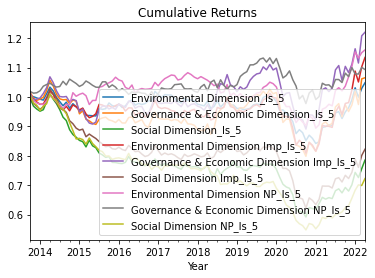

In [90]:
#Plot return time-series:

fct_df = rdata.copy(deep=True)
fct_df = fct_df.set_index('month_id')

factors = list(fct_df.loc[:,fct_df.columns.str.contains('ls')].columns)

for f in factors:
    #fn = ['cr' + f] 
    #fct_df[fn[0]] = np.log(1+fct_df[f]/100)
    #fct_df[fn[0]] = np.exp(np.cumsum(fct_df[fn[0]]))
    
    #((1+(fct_df.set_index(['month_id']).f/100)).cumprod()).plot(title='Cumulative Returns of ' + f)
    #((1+(fct_df[f]/100)).cumprod()).plot(title='Cumulative Returns of ' + f).legend()
    ((1+(fct_df[f]/100)).cumprod()).plot(title='Cumulative Returns', xlabel='Year').legend()

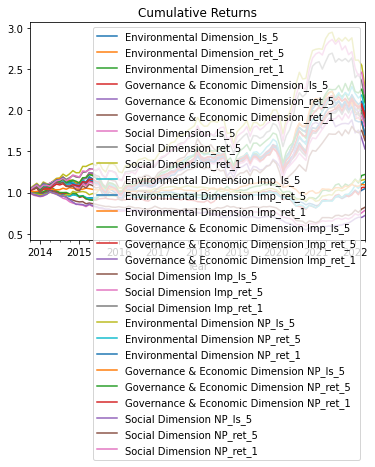

In [93]:
for v in reg_vars_new:
    ((1+(fct_df[v+'_ls_5']/100)).cumprod()).plot(title='Cumulative Returns', xlabel='Year').legend()
    ((1+(fct_df[v+'_ret_5']/100)).cumprod()).plot(title='Cumulative Returns', xlabel='Year').legend()
    ((1+(fct_df[v+'_ret_1']/100)).cumprod()).plot(title='Cumulative Returns', xlabel='Year').legend()
    